In [1]:
from NoisyCircuits.utils.BuildQubitGateModelParallel import BuildModel as Parallel
from NoisyCircuits.utils.BuildQubitGateModelSingleOptimized import BuildModel as SingleOpt
from NoisyCircuits.utils.BuildQubitGateModel import BuildModel as Single
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.sparse import identity, csr_matrix
with open("../noise_models/Noise_Model_Heron_QPU.pkl", "rb") as f:
    noise_model = pickle.load(f)

In [2]:
def compare(n_qubits):

    def compare_sparse(mat1, mat2):
        mat1 = csr_matrix(mat1).toarray()
        mat2 = csr_matrix(mat2).toarray()
        return np.allclose(mat1, mat2)
    
    def compare_dictionaries(dict1, dict2):
        single_old, two_old = dict1
        single_new, two_new = dict2
        for qubit in single_old.keys():
            for gate in single_old[qubit].keys():
                kraus_ops_new = single_new[qubit][gate]["kraus_operators"]
                kraus_ops_old = single_old[qubit][gate]["kraus_operators"]
                for k in range(len(kraus_ops_new)):
                    assert compare_sparse(kraus_ops_new[k], kraus_ops_old[k]), f"Single qubit gate mismatch on qubit {qubit} gate {gate} operator {k}"
                qubit_channel_new = single_new[qubit][gate]["qubit_channel"]
                qubit_channel_old = single_old[qubit][gate]["qubit_channel"]
                for k in range(len(qubit_channel_new)):
                    assert compare_sparse(qubit_channel_new[k], qubit_channel_old[k]), f"Single qubit channel mismatch on qubit {qubit} gate {gate} operator {k}"
            
        for gate in two_old.keys():
            for qubit_pair in two_old[gate].keys():
                kraus_ops_new = two_new[gate][qubit_pair]["operators"]
                kraus_ops_old = two_old[gate][qubit_pair]["operators"]
                for k in range(len(kraus_ops_new)):
                    assert compare_sparse(kraus_ops_new[k], kraus_ops_old[k]), f"Two qubit gate mismatch on qubits {qubit_pair} gate {gate} operator {k}"
                gate_channel_new = two_new[gate][qubit_pair]["qubit_channel"]
                gate_channel_old = two_old[gate][qubit_pair]["qubit_channel"]
                for k in range(len(gate_channel_new)):
                    assert compare_sparse(gate_channel_new[k], gate_channel_old[k]), f"Two qubit channel mismatch on qubits {qubit_pair} gate {gate} operator {k}"
        return True
    
    time_data = {
        # "Old" : [],
        "Single": [],
        "Parallel": []
    }
    for _ in range(3):
        # t0 = time.perf_counter_ns()
        # vals_old = Single(
        #             noise_model=noise_model,
        #             num_qubits=n_qubits,
        #             threshold=1e-15,
        #             basis_gates=[["sx", "x", "rz", "rx"], ["cz", "rzz"]],
        #             verbose=False).build_qubit_gate_model()
        # t1 = time.perf_counter_ns()
        # time_data["Old"].append(t1 - t0)
        t0 = time.perf_counter_ns()
        vals_single = SingleOpt(
                    noise_model=noise_model,
                    num_qubits=n_qubits,
                    num_cores=n_qubits,
                    threshold=1e-15,
                    basis_gates=[["sx", "x", "rz", "rx"], ["cz", "rzz"]],
                    verbose=False).build_qubit_gate_model()
        t1 = time.perf_counter_ns()
        time_data["Single"].append(t1 - t0)
        t0 = time.perf_counter_ns()
        vals_parallel = Parallel(
                    noise_model=noise_model,
                    num_qubits=n_qubits,
                    num_cores=n_qubits,
                    threshold=1e-15,
                    basis_gates=[["sx", "x", "rz", "rx"], ["cz", "rzz"]],
                    verbose=False).build_qubit_gate_model()
        t1 = time.perf_counter_ns()
        time_data["Parallel"].append(t1 - t0)
    # single_old, two_old, _, _ = vals_old
    single_single, two_single, _, _ = vals_single
    single_parallel, two_parallel, _, _ = vals_parallel
    # if compare_dictionaries((single_old, two_old), (single_single, two_single)) and compare_dictionaries((single_old, two_old), (single_parallel, two_parallel)):
    #     return time_data
    # if compare_dictionaries((single_single, two_single), (single_parallel, two_parallel)):
    #     return time_data
    # raise ValueError("Models do not match.")
    return time_data

In [3]:
qubits_data = {
    "qubits":[],
    "mean": [[], []],
    "std": [[], []]
}
for n_qubits in range(1, 16):
    data = compare(n_qubits)
    qubits_data["qubits"].append(n_qubits)
    for i, key in enumerate(["Single", "Parallel"]):
        qubits_data["mean"][i].append(np.mean(data[key]) / 1e9)
        qubits_data["std"][i].append(np.std(data[key]) / 1e9)
    print(f"Completed {n_qubits} qubits.")

Completed 1 qubits.
Completed 2 qubits.
Completed 3 qubits.
Completed 4 qubits.
Completed 5 qubits.
Completed 6 qubits.
Completed 7 qubits.
Completed 8 qubits.
Completed 9 qubits.
Completed 10 qubits.
Completed 11 qubits.
Completed 12 qubits.
Completed 13 qubits.
Completed 14 qubits.
Completed 15 qubits.


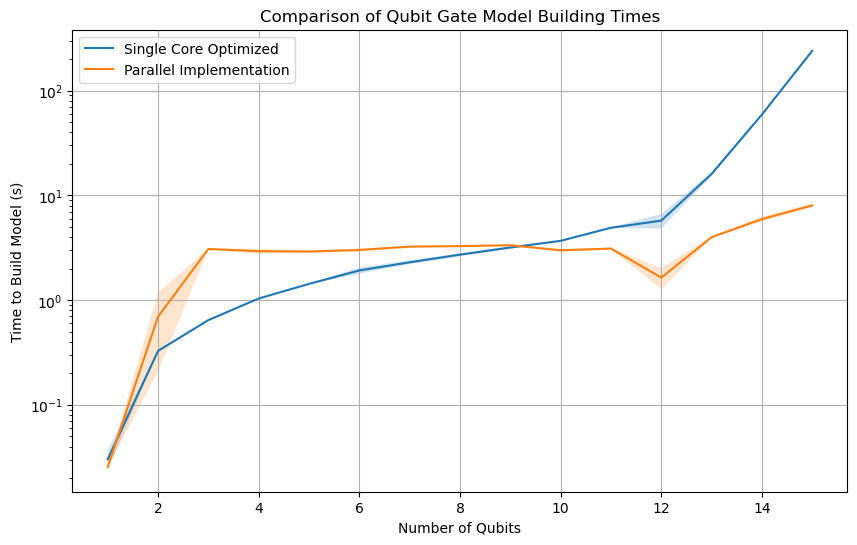

In [4]:
plt.figure(figsize=(10, 6))
label_list = ["Single Core Optimized", "Parallel Implementation"]
for i in range(2):
    plt.semilogy(qubits_data["qubits"], qubits_data["mean"][i], label=label_list[i])
    plt.fill_between(qubits_data["qubits"],
                     np.array(qubits_data["mean"][i]) - np.array(qubits_data["std"][i]),
                     np.array(qubits_data["mean"][i]) + np.array(qubits_data["std"][i]),
                     alpha=0.2)
plt.xlabel("Number of Qubits")
plt.ylabel("Time to Build Model (s)")
plt.title("Comparison of Qubit Gate Model Building Times")
plt.legend()
plt.grid()
plt.show()

In [17]:
vals_parallel = Parallel(
                    noise_model=noise_model,
                    num_qubits=16,
                    num_cores=16,
                    threshold=1e-15,
                    basis_gates=[["sx", "x", "rz", "rx"], ["cz", "rzz"]],
                    verbose=False).build_qubit_gate_model()

single_dict, two_dict, measurement, connect = vals_parallel

In [8]:
from pympler import asizeof

In [18]:
size = asizeof.asizeof(vals_parallel)
print(f"Size of parallel model: {size / 1024 / 1024 / 1024:.6f} GB")

Size of parallel model: 15.074764 GB


In [7]:
152992 / 1024 / 1024 

0.145904541015625

In [8]:
import numpy as np
from scipy.sparse import csr_matrix

def swap_big_endian_qubits_csr(M, n, qA, qB):
    # 1. Map Qubit IDs to Big-Endian bit positions
    posA = (n - 1) - qA
    posB = (n - 1) - qB
    
    num_states = 2**n
    permutation = np.arange(num_states)
    
    # 2. Extract bits at those positions
    bitA = (permutation >> posA) & 1
    bitB = (permutation >> posB) & 1
    
    # 3. Create the permutation array by flipping bits where they differ
    mask = bitA ^ bitB
    permutation ^= (mask << posA) | (mask << posB)
    
    # 4. Reorder the CSR matrix
    # M[permutation, :] swaps the rows
    # M[:, permutation] swaps the columns
    return M[permutation, :][:, permutation]

def compare_csr_tuples(t1, t2):
    """Compares two CSR tuples (data, indices, indptr)."""
    d1, i1, p1 = t1
    d2, i2, p2 = t2
    
    # Check shapes
    if d1.shape != d2.shape or i1.shape != i2.shape or p1.shape != p2.shape:
        return False, "Shape mismatch"
    
    # Check content
    if not np.allclose(d1, d2):
         diff = np.linalg.norm(d1 - d2)
         return False, f"Data mismatch (norm diff: {diff})"
    if not np.array_equal(i1, i2):
        return False, "Indices mismatch"
    if not np.array_equal(p1, p2):
        return False, "Indptr mismatch"
        
    return True, "Match"

summary = {}
print("Comparing operators for reversed qubit pairs (e.g. (0,1) vs (1,0))...")

for gate, gate_data in two_dict.items():
    processed_pairs = set()
    summary[gate] = {"total_pairs": 0, "matches": 0, "mismatches": 0, "examples": []}
    
    for pair in gate_data:
        rev_pair = (pair[1], pair[0])
        normalized_pair = tuple(sorted(pair))
        
        if normalized_pair in processed_pairs:
            continue
            
        if rev_pair in gate_data:
            processed_pairs.add(normalized_pair)
            summary[gate]["total_pairs"] += 1
            
            ops1 = gate_data[pair]['operators']
            ops2 = gate_data[rev_pair]['operators']
            
            match = True
            msg = ""
            
            if len(ops1) != len(ops2):
                match = False
                msg = f"Length mismatch: {len(ops1)} vs {len(ops2)}"
            else:
                for i, (op1, op2) in enumerate(zip(ops1, ops2)):
                    m, compare_msg = compare_csr_tuples(op1, op2)
                    if not m:
                        match = False
                        msg = f"Op {i}: {compare_msg}"
                        break
            
            if match:
                summary[gate]["matches"] += 1
            else:
                summary[gate]["mismatches"] += 1
                if len(summary[gate]["examples"]) < 5:
                    summary[gate]["examples"].append(f"{pair} vs {rev_pair}: {msg}")

for gate, stats in summary.items():
    print(f"Gate: {gate}")
    print(f"  Total pairs compared: {stats['total_pairs']}")
    print(f"  Matches: {stats['matches']}")
    print(f"  Mismatches: {stats['mismatches']}")
    if stats['examples']:
        print(f"  Mismatch examples:")
        for ex in stats['examples']:
            print(f"    {ex}")


Comparing operators for reversed qubit pairs (e.g. (0,1) vs (1,0))...
Gate: cz
  Total pairs compared: 1
  Matches: 0
  Mismatches: 1
  Mismatch examples:
    (0, 1) vs (1, 0): Op 12: Indices mismatch
Gate: rzz
  Total pairs compared: 0
  Matches: 0
  Mismatches: 0
